```C++
for (int64_t ific = 0; ific < nfic ; ++ific )
      { 
        //periodicité en Imax et Imin
        for (int64_t j = 0; j < Ndim_tab[1]  ; ++j )
        {  
        //Imin
        int l0   = ific +j*Ndim_tab[0]; 
        int l1   = l0 + Ndim_tab[0] - 2*nfic;

        Tout[l0] = Tout[l1];

        //Imax
        l0   = ific + (j+1)*Ndim_tab[0] - nfic;
        l1   = l0 - Ndim_tab[0] + 2*nfic;

        Tout[l0] = Tout[l1];
        }
      }

```

In [73]:
import numpy as np
import pylab as plt

In [74]:
nfic = 2
nbp = 3
dim = [20,20]

In [75]:
def vision(rank, nbp) : 
    Ndim_tab = []
    Ndim_tab.append(int(dim[0]/nbp) + (1 if(rank < dim[0]%nbp) else 0) +2*nfic)
    Ndim_tab.append(dim[1]+2*nfic)

    l_l0 = []
    l_l1 = []
    for ific in range(0, nfic) :
        l_l0.append([])
        l_l1.append([])
        for j in range(0, Ndim_tab[1]) :
            l0   = ific + (j+1)*Ndim_tab[0] - nfic
            l1   = l0 - Ndim_tab[0] + 2*nfic

            l_l0[ific].append(l0)
            l_l1[ific].append(l1)        

    lm0 = np.zeros(Ndim_tab[0]*Ndim_tab[1])
    lm0[l_l0[0]] = 1
    lm0[l_l0[1]] = 2
    lm1 = np.zeros(Ndim_tab[0]*Ndim_tab[1])
    lm1[l_l1[0]] = 1
    lm1[l_l1[1]] = 2


    ############################
    l_l0 = []
    l_l1 = []
    for ific in range(0, nfic) :
        l_l0.append([])
        l_l1.append([])
        for j in range(0, Ndim_tab[1]) :
            
            l0 = ific + j*Ndim_tab[0]
            l1 = l0 + Ndim_tab[0] - 2*nfic

            l_l0[ific].append(l0)
            l_l1[ific].append(l1)

    # l = np.arange(Ndim_tab[0]*Ndim_tab[1])
    lm0[l_l0[0]] = -1
    lm0[l_l0[1]] = -2

    lm1[l_l1[0]] = -1
    lm1[l_l1[1]] = -2
    ##################################
     
    M0 = lm0.reshape(Ndim_tab[1],Ndim_tab[0])
    M1 = lm1.reshape(Ndim_tab[1], Ndim_tab[0])

    grad = np.arange(Ndim_tab[0]*Ndim_tab[1]).reshape(Ndim_tab[1],Ndim_tab[0])

    return (M0, M1, grad)

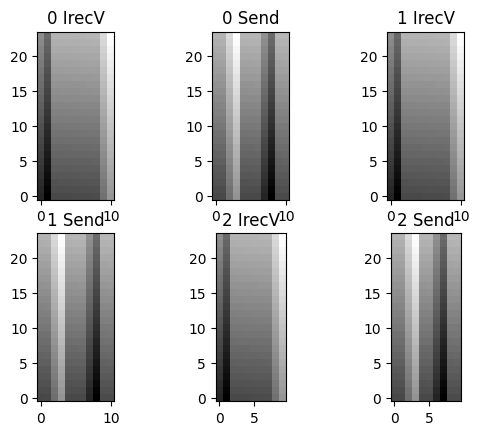

In [76]:
plt.subplots(2,nbp)
for rank in range(nbp) :
    (M0, M1, grad) = vision(rank, nbp)

    plt.subplot(2,nbp,1+2*rank)
    plt.imshow(M0 + 3*grad/grad.size, cmap="gray")
    plt.gca().invert_yaxis()
    plt.title("{} IrecV".format(rank))
    
    plt.subplot(2,nbp,2+2*rank)
    plt.imshow(M1 +3*grad/grad.size, cmap="gray")
    plt.gca().invert_yaxis()
    plt.title("{} Send".format(rank))
    

## Understanding the sequential program

Variables : 
```C++
int nfic; // Nombre de cellule fantome
int dim[2]; // dimension en x et en y sans les cellules fantomes
int Ndim_tab[2]; // dimension du tableau en x et y en comptant les cellules phantomes
double x[Ndim_tab[0]]; // discretisation en x
double y[Ndim_tab[1]]; // discretisation en y
double bilan[Ndim_tab[0]*Ndim_tab[1]]; // bilan intial
double T1[Ndim_tab[0]*Ndim_tab[1]]; // Temperature initial
double T0[Ndim_tab[0]*Ndim_tab[1]]; // Temperature final
int dx[2]; // pas de discretisation en x et y
double dt; // pas de discretisation en temps
double U[2]; //scalaire vitesse supposé comme constante
double mu; // Coeff de diffusion
int Nitmax; // Nombre d'iteration
int Stepmax; // Nombre pas de schéma
```

Fonction : 
```C++
void init( int* ndim_tab, int* dim, double* T0, double* x , double* y, double* dx, int rank, int nbp);
void advection( int* ndim_tab,   double* T, double* bilan, double* dx, double* a, int step );
void diffusion( int* ndim_tab,   double* T, double* bilan, double* dx, const double mu );
void mise_a_jour( int* ndim_tab,   double* T0, double* T1, double* bilan, const double dt);
int main( int nargc, char* argv[])
{
    //fait tout les allocations en espaces et les initialisations nécessaires
    init( Ndim_tab, dim, T0, x, y, dx);
    
    //Boucle en temps
    for (int64_t nit = 0; nit < Nitmax ; ++nit )
    { 
        //Boucle Runge-Kutta
        double *Tin; // Temperature input
        double *Tout; // Temperature output
        double *Tbilan; // Temperature bilan

        for (int64_t step = 0; step < Stepmax ; ++step )
        { 
        //mise a jour point courant
        if(step==0) { Tin = T0; Tout= T1; Tbilan= T0;}
        else        { Tin = T0; Tout= T0; Tbilan= T1;}

        //advection
        advection(Ndim_tab, Tbilan, bilan,  dx, U , step);

        diffusion(Ndim_tab, Tbilan, bilan,  dx, mu);

        mise_a_jour(Ndim_tab, Tin, Tout, bilan,  dt);

        //Application Condition limite
        for (int64_t ific = 0; ific < nfic ; ++ific )
        {  
            //periodicité en Jmax et Jmin
            for (int64_t i = 0; i < Ndim_tab[0]  ; ++i )
            {  
            //Jmin

            //Jmax
            }
        }

        for (int64_t ific = 0; ific < nfic ; ++ific )
        {
            //...
        }

        }  // Nstepmax
        }  // Nitmax
    }
```

```C++
// MPI Stuff
  MPI_Request request[2];
  int nbp{0};
  int rank{0};
  MPI_Status stats;
  MPI_Comm world;
```

In [77]:
a = 27
b = 5
r = a%b

In [78]:
6+6+5+5+5

27

In [79]:
shift = 0
rank = 4
for s in range(rank) :
    shift += (s<r)

In [80]:
dim = [500, 500]
nbp = 3
rank = 0
nfic = 2
Ndim_tab = [0,0]

Ndim_tab[0] = (dim[0]/nbp) + (1 if(rank < dim[0]%nbp) else 0) + 2*nfic
Ndim_tab[1] = dim[1]+2*nfic
b_s = 0
b = 0

In [81]:
for rank in range(nbp) :
    for rac in range(2) :
        if(rac == 0) :
            if(rank == 0) :
                rank_donor = nbp - 1
            else :
                rank_donor = rank - 1
            shift = 0
        else :
            if(rank == nbp - 1) :
                rank_donor = 0
            else :
                rank_donor = rank + 1
            shift = Ndim_tab[1]*nfic
        
        etiquette = (rank + 10000*rank_donor)*(1000 if(rac == 0) else 1)
        
        size     = Ndim_tab[1]*nfic
        print("{} <--- {} ({}), size : {}, Ad1 : {}".format(rank, rank_donor, etiquette, size, b_s + shift ))

0 <--- 2 (20000000), size : 1008, Ad1 : 0
0 <--- 1 (10000), size : 1008, Ad1 : 1008
1 <--- 0 (1000), size : 1008, Ad1 : 0
1 <--- 2 (20001), size : 1008, Ad1 : 1008
2 <--- 1 (10002000), size : 1008, Ad1 : 0
2 <--- 0 (2), size : 1008, Ad1 : 1008


In [82]:
for rank in range(nbp): 
    for rac in range(2) :
        if(rac == 0) :
            if(rank == 0): 
                rank_dest = nbp - 1
            else :
                rank_dest = rank - 1
            shift = 0
        else :
            if(rank == nbp - 1) :
                rank_dest = 0
            else :
                rank_dest = rank + 1
            shift = Ndim_tab[1]*nfic
        etiquette= (10000*rank + rank_dest)*(1000 if(rac == 1) else 1)

        size     = Ndim_tab[1]*nfic
        print("{} ---> {} ({}), size : {}, Ad1 : {}".format(rank, rank_dest, etiquette, size, b + shift))

0 ---> 2 (2), size : 1008, Ad1 : 0
0 ---> 1 (1000), size : 1008, Ad1 : 1008
1 ---> 0 (10000), size : 1008, Ad1 : 0
1 ---> 2 (10002000), size : 1008, Ad1 : 1008
2 ---> 1 (20001), size : 1008, Ad1 : 0
2 ---> 0 (20000000), size : 1008, Ad1 : 1008
